In [78]:
import os
import pandas as pd
from tqdm import tqdm

Read files


In [79]:
# read files from output directory
output_dir = '../output'
output_files = os.listdir(output_dir)
output_files 

['llava_img_True_country_True.csv',
 'llava_img_False_country_False.csv',
 'llava_img_True_country_False.csv',
 'llava_img_False_country_True.csv']

In [80]:
from datasets import load_dataset

go_dataset = load_dataset("Anthropic/llm_global_opinions")

# load as a pandas dataframe where 'source' == wvs
go_dataset_df = go_dataset['train'].to_pandas()
go_dataset_wvs = go_dataset_df[go_dataset_df['source'] == 'WVS']
go_dataset_wvs.head()

Using the latest cached version of the dataset since Anthropic/llm_global_opinions couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/srishti/.cache/huggingface/datasets/Anthropic___llm_global_opinions/default/0.0.0/cb2880488749218abb81802a94c2c62ebfde2f35 (last modified on Thu May  2 16:07:53 2024).


question  \
2203  How satisfied are you with the following?\n\nT...   
2204  Please tell us if you strongly agree, agree, d...   
2205  Please tell us if you strongly agree, agree, d...   
2206  In your view, how often do the following thing...   
2207  I am going to name a number of organizations. ...   

                                             selections  \
2203  defaultdict(<class 'list'>, {'Iraq': [0.288000...   
2204  defaultdict(<class 'list'>, {'Ethiopia': [0.07...   
2205  defaultdict(<class 'list'>, {'Ethiopia': [0.21...   
2206  defaultdict(<class 'list'>, {'Albania': [0.075...   
2207  defaultdict(<class 'list'>, {'Hong Kong SAR': ...   

                                                options source  
2203  ['Completely dissatisfied', 'Rather dissatisfi...    WVS  
2204  ['Strongly agree', 'Agree', 'Disagree', 'Stron...    WVS  
2205  ['Strongly agree', 'Agree', 'Disagree', 'Stron...    WVS  
2206  ['Very often', 'Fairly often', 'Not often', 'N...    WVS  
2207  ['A great deal', 'Quite a lot', 'Not very much...    WVS

In [81]:
import shutil
img_comparison = False
img_country_comparison = True

if img_comparison:
    file_1 = os.path.join(output_dir, 'llava_img_True_country_False.csv')
    file_2 = os.path.join(output_dir, 'llava_img_False_country_False.csv')
    image_dir = '../jsd_percountry_images_true_country_false'
elif img_country_comparison:
    file_1 = os.path.join(output_dir, 'llava_img_True_country_True.csv')
    file_2 = os.path.join(output_dir, 'llava_img_False_country_True.csv')
    image_dir = '../jsd_percountry_images_true_country_true'


# delete all files in the directory if exists
if os.path.exists(image_dir):
    shutil.rmtree(image_dir)
os.makedirs(image_dir)

df_1 = pd.read_csv(file_1) # image true
df_2 = pd.read_csv(file_2) # image false

In [82]:
import ast

def convert_to_list(x):
    x = ast.literal_eval(x) 
    x_list = list(x.values()) if isinstance(x, dict) else list(x)
    return x_list

def get_distribution_list(df, options_prob_col, wvs_distribution_col):
    options_prob_dict = [convert_to_list(val) for val in df[options_prob_col]]
    df['options_prob_list'] = pd.Series(options_prob_dict)
    
    wvs_distribution = [convert_to_list(val) for val in df[wvs_distribution_col]]
    df['wvs_distribution_list'] = wvs_distribution
    
    return df

# Assuming df_1 and df_2 are already defined DataFrames
df_1 = get_distribution_list(df_1, 'options_prob', 'wvs_distribution')
df_2 = get_distribution_list(df_2, 'options_prob', 'wvs_distribution')

In [83]:
wvs_questions = go_dataset_wvs['question'].unique()
model_questions = df_1['question'].unique()

common_questions = set(wvs_questions).intersection(set(model_questions))
len(common_questions)

# for all unique value in questions column, find "options" value from go_dataset_wvs and add to df_aggregated
def add_options_to_df(questions, df_aggregated, go_dataset_wvs):
    for question in questions:
        options = go_dataset_wvs[go_dataset_wvs['question'] == question]['options'].values[0]
        # create a new column with options
        # breakpoint()

        df_aggregated.loc[df_aggregated['question'] == question, 'options'] = options
    return df_aggregated

df_aggregated_1 = add_options_to_df(common_questions, df_1, go_dataset_wvs)
df_aggregated_2 = add_options_to_df(common_questions, df_2, go_dataset_wvs)

In [84]:
df_aggregated_1.head(2)

useimage  usecountry  ques_idx  \
0      True        True         0   
1      True        True         0   

                                            question  \
0  How satisfied are you with the following?\n\nT...   
1  How satisfied are you with the following?\n\nT...   

                   image_id  \
0  5d4be99dcf0b3a0f3f348f34   
1  5d4beb8fcf0b3a0f3f34c73c   

                                            img_path  country  \
0  data/dollarstreet/assets/5d4be99dcf0b3a0f3f348...   Jordan   
1  data/dollarstreet/assets/5d4beb8fcf0b3a0f3f34c...  Lebanon   

                                    top10_token_prob  \
0  [('C', 0.32552385330200195), ('D', 0.320477098...   
1  [('D', 0.3295651376247406), ('C', 0.2818920016...   

                                options_prob_percent  \
0  {'A': 5.0, 'B': 7.000000000000001, 'C': 33.0, ...   
1  {'A': 6.0, 'B': 7.000000000000001, 'C': 28.000...   

                                        options_prob  \
0  {'A': 0.05231644585728645, 'B': 0.068233504891...   
1  {'A': 0.06192345544695854, 'B': 0.074693948030...   

                                    wvs_distribution  \
0  [0.363, 0.389, 0.168, 0.059000000000000004, 0....   
1  [0.121, 0.299, 0.418, 0.08199999999999999, 0.0...   

                                              prompt  \
0  How would someone from Jordan  answer the foll...   
1  How would someone from Lebanon  answer the fol...   

                                   options_prob_list  \
0  [0.05231644585728645, 0.06823350489139557, 0.3...   
1  [0.06192345544695854, 0.0746939480304718, 0.28...   

                               wvs_distribution_list  \
0  [0.363, 0.389, 0.168, 0.059000000000000004, 0....   
1  [0.121, 0.299, 0.418, 0.08199999999999999, 0.0...   

                                             options  
0  ['Completely dissatisfied', 'Rather dissatisfi...  
1  ['Completely dissatisfied', 'Rather dissatisfi...

In [85]:
df_aggregated_2.head(2)

useimage  usecountry  ques_idx  \
0     False        True         0   
1     False        True         0   

                                            question  image_id  img_path  \
0  How satisfied are you with the following?\n\nT...       NaN       NaN   
1  How satisfied are you with the following?\n\nT...       NaN       NaN   

   country                                   top10_token_prob  \
0   Jordan  [('C', 0.5658066272735596), ('D', 0.2286065369...   
1  Lebanon  [('C', 0.5233020186424255), ('D', 0.2550370395...   

                                options_prob_percent  \
0  {'A': 4.0, 'B': 8.0, 'C': 56.99999999999999, '...   
1  {'A': 5.0, 'B': 8.0, 'C': 52.0, 'D': 26.0, 'E'...   

                                        options_prob  \
0  {'A': 0.04163234308362007, 'B': 0.076573595404...   
1  {'A': 0.05262986570596695, 'B': 0.081514731049...   

                                    wvs_distribution  \
0  [0.363, 0.389, 0.168, 0.059000000000000004, 0....   
1  [0.121, 0.299, 0.418, 0.08199999999999999, 0.0...   

                                              prompt  \
0  How would someone from Jordan  answer the foll...   
1  How would someone from Lebanon  answer the fol...   

                                   options_prob_list  \
0  [0.04163234308362007, 0.07657359540462494, 0.5...   
1  [0.05262986570596695, 0.08151473104953766, 0.5...   

                               wvs_distribution_list  \
0  [0.363, 0.389, 0.168, 0.059000000000000004, 0....   
1  [0.121, 0.299, 0.418, 0.08199999999999999, 0.0...   

                                             options  
0  ['Completely dissatisfied', 'Rather dissatisfi...  
1  ['Completely dissatisfied', 'Rather dissatisfi...

In [110]:
# Initialize the new column with empty dictionaries

def create_joint_dict(country, df, questions):
    """ This function returns a dict which has questions as keys and distribution for that question as values"""
    joint_dict = {}

    breakpoint()
    joint_dict[country] = [
                            [question, 
                            df[(df['question'] == question) & (df['country'] == country)]['options_prob_list'].values[0],
                            df[(df['question'] == question) & (df['country'] == country)]['wvs_distribution_list'].values[0],
                            df[(df['question'] == question) & (df['country'] == country)]['options'].values[0]
                            ] for question in questions]

    return joint_dict


def create_joint_dict_all_countries(df1, df2):
    countries = df1['country'].unique()
    joint_dict_df1 = []
    joint_dict_df2 = []
    for country in tqdm(countries):
        questions = df_1[df_1['country'] == country]['question'].unique()
        joint_dict_df1.append(create_joint_dict(country, df1, questions))
        joint_dict_df2.append(create_joint_dict(country, df2, questions))

    return joint_dict_df1, joint_dict_df2

joint_dict_country_df1, joint_dict_country_df2 = create_joint_dict_all_countries(df_aggregated_1, df_aggregated_2)

100%|██████████| 42/42 [00:34<00:00,  1.23it/s]


In [87]:
# joint_dict_country_df1

In [88]:
# joint_dict_country_df2

In [89]:
import scipy
import numpy as np
from scipy.spatial.distance import jensenshannon

# for each country, calculate jsd for each question. Average the jsd for all questions per country

def calculate_jsd(joint_dict_country_wvs_options):
    jsd_questions = {}
    for country_dict in tqdm(joint_dict_country_wvs_options):
        country = list(country_dict.keys())[0]
        similarity = [1 -jensenshannon(val[1], val[2]) for country_name, ques_vals in country_dict.items() for val in ques_vals]
        # remove nan values
        similarity = [val for val in similarity if not np.isnan(val)]
        breakpoint()
        jsd_questions[country] = np.mean(similarity)
        # find value 173 in country_dict
        # val_173 = [val for val in country_dict[country] if val[0] == 173]
    return jsd_questions

jsd_country_df1 = calculate_jsd(joint_dict_country_df1)
jsd_country_df2 = calculate_jsd(joint_dict_country_df2)

  0%|          | 0/42 [00:00<?, ?it/s]/home/srishti/dev/cultural_values/cultural_values/lib/python3.10/site-packages/scipy/spatial/distance.py:1262: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
100%|██████████| 42/42 [00:00<00:00, 354.50it/s]


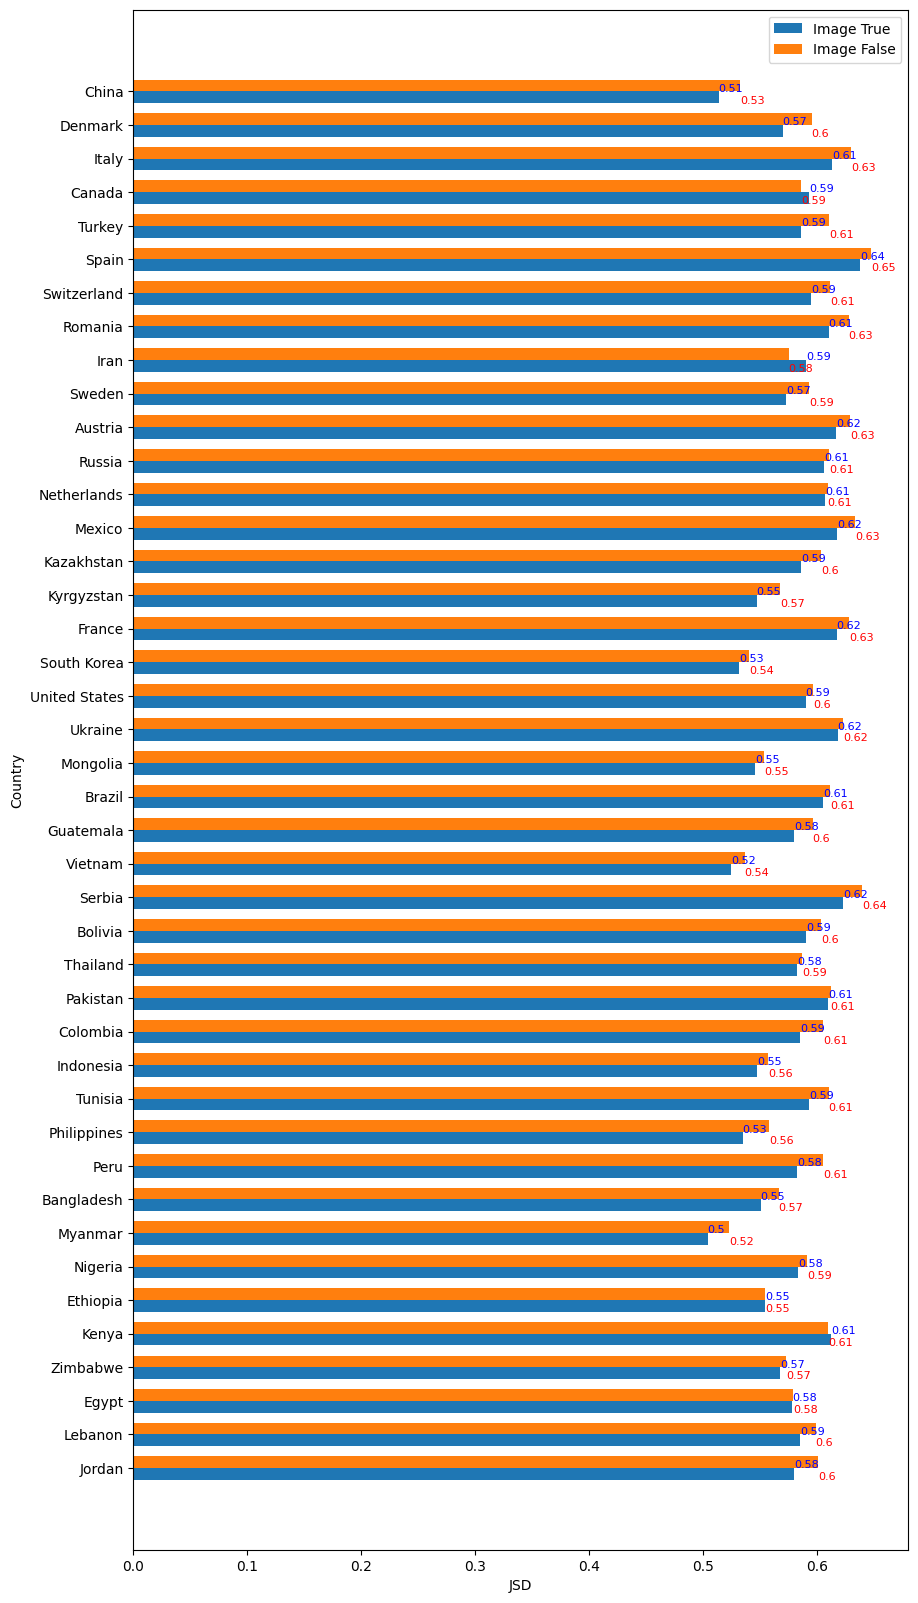

In [90]:
# Plot the jsd values for each country side by side in bar chart
# make country as y-axis and jsd as x-axis

import matplotlib.pyplot as plt

def plot_jsd(jsd_country_df1, jsd_country_df2):
    fig, ax = plt.subplots( figsize=(10, 20))
    # make country as y-axis and jsd as x-axis
    countries = list(jsd_country_df1.keys())
    jsd_values_df1 = list(jsd_country_df1.values())
    jsd_values_df2 = list(jsd_country_df2.values())
    x = np.arange(len(countries))
    width = 0.35

    # add the jsd values at the end of the bar
    for i, v in enumerate(jsd_values_df1):
        ax.text(v, i, str(round(v, 2)), color='blue', fontsize=8)
    # text is not alligned properly. make it a little down
    for i, v in enumerate(jsd_values_df2):
        ax.text(v, i-0.35, str(round(v, 2)), color='red', fontsize=8)

    ax.barh(x - width/2, jsd_values_df1, width, label='Image True')
    ax.barh(x + width/2, jsd_values_df2, width, label='Image False')

    ax.set_xlabel('JSD')
    ax.set_ylabel('Country')
    ax.set_yticks(x)
    ax.set_yticklabels(countries)
    ax.legend()

    plt.show()

plot_jsd(jsd_country_df1, jsd_country_df2)

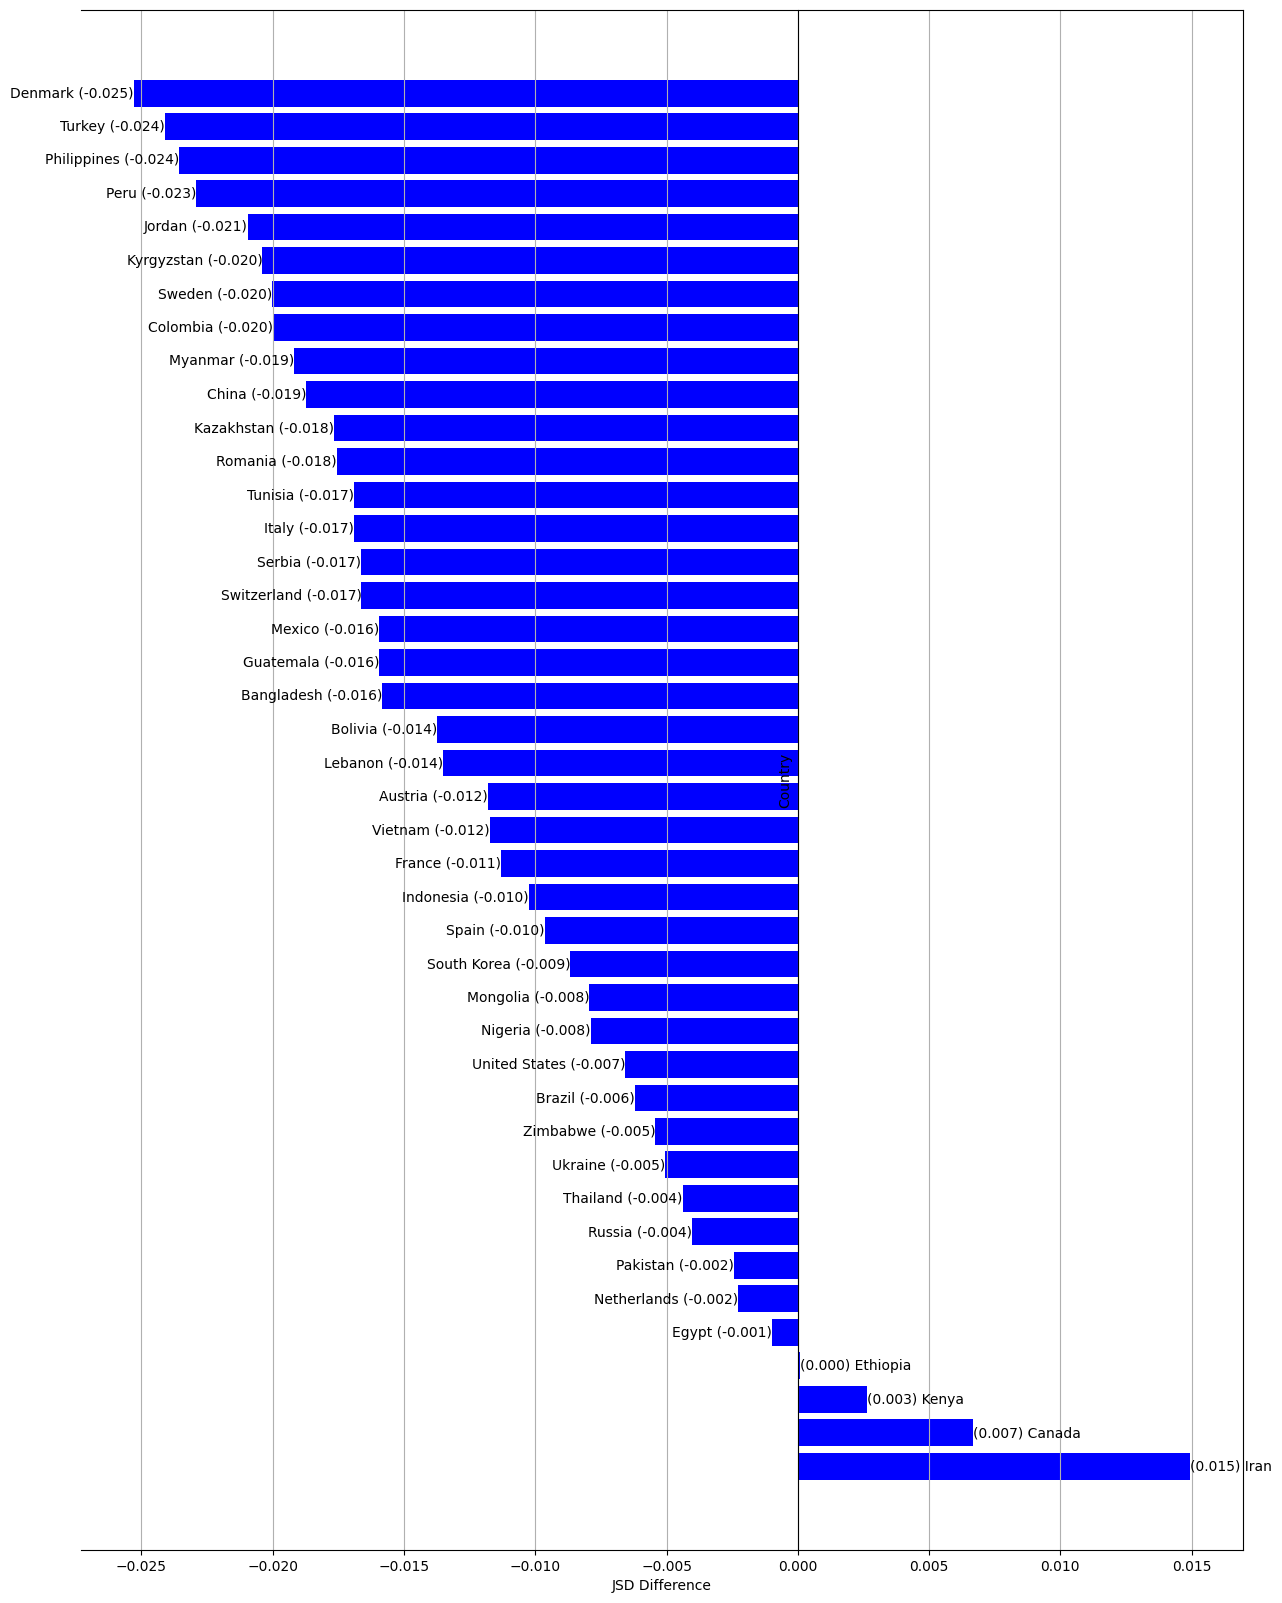

In [91]:

def plot_jsd_difference(jsd_country_df1, jsd_country_df2):
    # Calculate the JSD difference
    jsd_diff = {country: jsd_country_df1[country] - jsd_country_df2[country] for country in jsd_country_df1.keys()}
    jsd_diff = dict(sorted(jsd_diff.items(), key=lambda item: item[1], reverse=True))

    countries = list(jsd_diff.keys())
    jsd_diff_values = list(jsd_diff.values())
    x = np.arange(len(countries))

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 20))
    bars = ax.barh(x, jsd_diff_values, color='blue')
    
    # Set labels
    ax.set_xlabel('JSD Difference')
    ax.set_ylabel('Country')

    # Remove the y-ticks and labels (we will add custom labels)
    ax.set_yticks([])
    
    # Move the y-axis to x=0
    ax.spines['left'].set_position(('data', 0))  # Move the left spine to x=0

    # Customize the grid and ticks
    ax.xaxis.grid(True)
    ax.tick_params(axis='y', which='both', left=True, right=False)

    # Add JSD values and country names at the end of the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        country_name = countries[i]
        if width < 0:
            # Bar extends to the left
            ax.text(width, bar.get_y() + bar.get_height() / 2, f'{country_name} ({width:.3f})',
                    va='center', ha='right', color='black', fontsize=10)
        else:
            # Bar extends to the right
            ax.text(width, bar.get_y() + bar.get_height() / 2, f'({width:.3f}) {country_name}', 
                    va='center', ha='left', color='black', fontsize=10)

    # Show the plot
    plt.show()

plot_jsd_difference(jsd_country_df1, jsd_country_df2)

In [92]:
a = [0, 0.2, 0.8, 0]
b = [0.1, 0.2, 0.9, 0]
ans = jensenshannon(a, b)
ans

0.17332931375220653

In [118]:
import scipy, copy
import numpy as np
from scipy.spatial.distance import jensenshannon

# for each country, calculate jsd for each question. Average the jsd for all questions per country

def calculate_jsd(joint_dict_country_wvs_options):
    for country_dict in tqdm(joint_dict_country_wvs_options):
        country = list(country_dict.keys())[0]
        for ques_vals in country_dict[country]:
            question, dist1, dist2 = ques_vals[0], np.array(ques_vals[1]), np.array(ques_vals[2])
            similarity = 1 - jensenshannon(dist1, dist2)
            breakpoint()
            ques_vals.append(similarity)

    return joint_dict_country_wvs_options

joint_dict_country_df1_selected = copy.deepcopy(joint_dict_country_df1)
joint_dict_country_df2_selected = copy.deepcopy(joint_dict_country_df2)

jsd_selected_df1 = calculate_jsd(joint_dict_country_df1_selected)
jsd_selected_df2 = calculate_jsd(joint_dict_country_df2_selected)

  0%|          | 0/42 [00:00<?, ?it/s]/home/srishti/dev/cultural_values/cultural_values/lib/python3.10/site-packages/scipy/spatial/distance.py:1262: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
100%|██████████| 42/42 [00:00<00:00, 285.19it/s]


In [120]:
jsd_selected_df1

[{'Jordan': [['How satisfied are you with the following?\n\nThe way the local authorities are solving the region’s affairs',
    [0.05231644585728645,
     0.06823350489139557,
     0.32552385330200195,
     0.32047709822654724,
     0.1769842505455017,
     0.055690567940473557],
    [0.363, 0.389, 0.168, 0.059000000000000004, 0.018000000000000002, 0.002],
    '[\'Completely dissatisfied\', \'Rather dissatisfied\', \'Rather satisfied\', \'Completely satisfied\', "Don\'t know", \'No answer\']',
    0.5068550711660282],
   ['In your view, how often do the following things occur in this country’s elections?\n\nOpposition candidates are prevented from running',
    [0.14378495514392853,
     0.080656036734581,
     0.3043927252292633,
     0.3908480107784271,
     0.03635452687740326,
     0.029671700671315193,
     0.01358469482511282],
    [0.09, 0.239, 0.195, 0.277, 0.2, 0.0, 0.0],
    '[\'Very often\', \'Fairly often\', \'Not often\', \'Not at all often\', "Don\'t know", \'No answer\'

In [122]:
# split jsd_selected_df1 such that one has questions etc with similarity  <= 0.5 and other has > 0.5
# do this for all countries

def split_jsd(jsd_selected_df):
    jsd_selected_df_low = []
    jsd_selected_df_low_country = {}
    jsd_selected_df_high = []
    jsd_selected_df_high_country = {}
    for country_dict in tqdm(jsd_selected_df):
        country = list(country_dict.keys())[0]
        for ques_vals in country_dict[country]:
            breakpoint()
            if ques_vals[3] <= 0.5:
                jsd_selected_df_low.append(ques_vals)
            else:
                jsd_selected_df_high.append(ques_vals)
        
    return jsd_selected_df_low, jsd_selected_df_high

jsd_selected_df1_low, jsd_selected_df1_high = split_jsd(jsd_selected_df1)




  0%|          | 0/42 [01:32<?, ?it/s]


TypeError: '<=' not supported between instances of 'str' and 'float'